In [36]:
pip install pca

Note: you may need to restart the kernel to use updated packages.


In [37]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from yellowbrick.cluster import KElbowVisualizer
from scipy import stats
import logging, sys
from pca import pca
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

In [38]:
url = "https://github.com/Valeria-Riccardo/market-analytics-datasets/blob/9ef3ba76fe20a91253db47f3403496284e76df0f/Segmentation.xlsx"
# Fix the URL to point to raw content
url = "https://raw.githubusercontent.com/Valeria-Riccardo/market-analytics-datasets/9ef3ba76fe20a91253db47f3403496284e76df0f/Segmentation.xlsx"

# Download the file using requests
import requests
response = requests.get(url)
with open('Segmentation.xlsx', 'wb') as f:
	f.write(response.content)

# Read the downloaded Excel file
df = pd.read_excel('Segmentation.xlsx')
df.head()

,Id,Gender,Age group,Profession,Income,Household size,House type,Nationality,Country of residence,Region (Italy),...,Average bill cost,Washing Machine,Dishwasher,Clothes dryer,Water heater,Electric oven,Daily energy consumption,Season,Loyalty,Times energy provider changed
0,1,Donna / Female,> 60,Dipendente pubblico / Public employee,Da 55.001€ a 75.000€ / From 55.001 to 75.000€,3,Casa indipendente (villa/villetta) / Independe...,Italiano / Italian,Italia / Italy,"Centro / Center (Toscana, Lazio, Umbria, March...",...,51-120€ al mese circa / 51-120€ per month appr...,3,3,1,1,5,Durante il giorno (7-18) / During the day (7am...,Estate / Summer,meno di un anno fa / less than 1 year ago,1 volta / Once
1,2,Uomo /Male,> 60,Dipendente pubblico / Public employee,Da 55.001€ a 75.000€ / From 55.001 to 75.000€,3,Casa indipendente (villa/villetta) / Independe...,Italiano / Italian,Italia / Italy,"Centro / Center (Toscana, Lazio, Umbria, March...",...,0-50€ al mese circa / 0-50€ per monthly approx...,2,1,1,1,1,Durante la sera (18-23) / During the evening (...,Inverno / Winter,meno di un anno fa / less than 1 year ago,1 volta / Once
2,3,Donna / Female,36 - 45,Dipendente pubblico / Public employee,Da 28.001€ a 55.000€ / From 28.001€ to 55.000€,1 (vivi da solo) / 1 (you live on your own),Appartamento (3 o più stanze) / Apartment (3 o...,Italiano / Italian,Italia / Italy,"Centro / Center (Toscana, Lazio, Umbria, March...",...,51-120€ al mese circa / 51-120€ per month appr...,5,5,1,1,3,Durante il giorno (7-18) / During the day (7am...,Estate / Summer,5+ anni fa / 5+ years ago,1 volta / Once
3,4,Donna / Female,26 - 35,Dipendente privato / Private employee,Da 15.001€ a 28.000€ / From 15.001€ to 28.000€,5+,Appartamento (3 o più stanze) / Apartment (3 o...,Italiano / Italian,Italia / Italy,"Nord Ovest /North West (Valle d'Aosta, Piemont...",...,0-50€ al mese circa / 0-50€ per monthly approx...,5,1,1,5,1,Durante la sera (18-23) / During the evening (...,Inverno / Winter,mai/never,NaN
4,5,Donna / Female,> 60,Dipendente pubblico / Public employee,15.000€ o meno / 15.000€ or less,2,Appartamento (3 o più stanze) / Apartment (3 o...,Italiano / Italian,Italia / Italy,"Centro / Center (Toscana, Lazio, Umbria, March...",...,51-120€ al mese circa / 51-120€ per month appr...,3,1,1,1,3,Durante la sera (18-23) / During the evening (...,Inverno / Winter,meno di un anno fa / less than 1 year ago,3 volte / 3 times


In [39]:
file_path = "Segmentation.xlsx"
xls = pd.ExcelFile(file_path)
df = pd.read_excel(xls, sheet_name='Sheet1')
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

In [40]:
missing_summary = df.isnull().sum().reset_index()
missing_summary.columns = ['Column', 'Missing Values']
missing_summary['Percentage'] = (missing_summary['Missing Values'] / len(df)) * 100

missing_summary = missing_summary[missing_summary['Missing Values'] > 0].sort_values(by='Missing Values', ascending=False)

print("Missing Value Summary")
display(missing_summary)

Missing Value Summary


,Column,Missing Values,Percentage
13,region_(uk),90,100.000000
10,region_(france),88,97.777778
12,region_(germany),88,97.777778
11,region_(spain),86,95.555556
24,times_energy_provider_changed,31,34.444444
9,region_(italy),8,8.888889


In [41]:
df['times_energy_provider_changed'] = df['times_energy_provider_changed'].str.extract('(\d+)').astype(float)
df['times_energy_provider_changed'] = df['times_energy_provider_changed'].fillna(df['times_energy_provider_changed'].median())

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\pooya\AppData\Local\Temp\ipykernel_27444\199423046.py:1: SyntaxWarning: invalid escape sequence '\d'
  df['times_energy_provider_changed'] = df['times_energy_provider_changed'].str.extract('(\d+)').astype(float)


In [42]:
def remove_italian_part(text, splitter=' / '):
    if isinstance(text, str) and splitter in text:
        return text.split(splitter)[1].strip()
    return text

columns_to_clean = ['gender', 'profession', 'income', 'household_size', 'house_type', 'nationality',
                    'country_of_residence', 'region_(italy)', 'region_(france)', 'region_(spain)',
                    'region_(germany)', 'owner_of_his/her_contract', 'average_bill_cost',
                    'daily_energy_consumption', 'season', 'loyalty']

for col in columns_to_clean:
    df[col] = df[col].apply(remove_italian_part)

splitter_character = ' / '
for col in columns_to_clean:
    df[col] = df[col].apply(remove_italian_part, splitter=splitter_character)

splitter_character = ' /'
df['region_(italy)'] = df['region_(italy)'].apply(remove_italian_part, splitter=splitter_character)

splitter_character = '/'
df['loyalty'] = df['loyalty'].apply(remove_italian_part, splitter=splitter_character)

df.drop(columns=['region_(uk)', 'region_(france)', 'region_(germany)'], inplace=True)

In [43]:
region_columns = ['region_(italy)', 'region_(spain)']
df[region_columns] = df[region_columns].fillna('Unknown')

income_mapping = {
    "15.000€ or less": "0-15000",
    "From 15.001€ to 28.000€": "15001-28000",
    "From 28.001€ to 55.000€": "28001-55000",
    "From 55.001 to 75.000€": "55001-75000",
    "Over 75.000€": "75000+"
}
df['income'] = df['income'].map(income_mapping)

df['average_bill_cost'] = df['average_bill_cost'].str.replace('€', '').str.replace(' per month', '').str.replace('ly', '').str.replace('approximate', '').str.strip()

df['gender'] = df['gender'].str.extract(r'(Female|Male)', expand=False)

df['household_size'] = df['household_size'].replace({
    '1 (you live on your own)': '1',
    '5+': '5'})

df.head()


,id,gender,age_group,profession,income,household_size,house_type,nationality,country_of_residence,region_(italy),...,average_bill_cost,washing_machine,dishwasher,clothes_dryer,water_heater,electric_oven,daily_energy_consumption,season,loyalty,times_energy_provider_changed
0,1,Female,> 60,Public employee,55001-75000,3,Independent living,Italian,Italy,"Center (Toscana, Lazio, Umbria, Marche, Molise)",...,51-120,3,3,1,1,5,During the day (7am- 6pm),Summer,less than 1 year ago,1.0
1,2,Male,> 60,Public employee,55001-75000,3,Independent living,Italian,Italy,"Center (Toscana, Lazio, Umbria, Marche, Molise)",...,0-50,2,1,1,1,1,During the evening (6pm-11pm),Winter,less than 1 year ago,1.0
2,3,Female,36 - 45,Public employee,28001-55000,1,Apartment (3 or more rooms),Italian,Italy,"Center (Toscana, Lazio, Umbria, Marche, Molise)",...,51-120,5,5,1,1,3,During the day (7am- 6pm),Summer,5+ years ago,1.0
3,4,Female,26 - 35,Private employee,15001-28000,5,Apartment (3 or more rooms),Italian,Italy,"North West (Valle d'Aosta, Piemonte, Lombardia...",...,0-50,5,1,1,5,1,During the evening (6pm-11pm),Winter,never,2.0
4,5,Female,> 60,Public employee,0-15000,2,Apartment (3 or more rooms),Italian,Italy,"Center (Toscana, Lazio, Umbria, Marche, Molise)",...,51-120,3,1,1,1,3,During the evening (6pm-11pm),Winter,less than 1 year ago,3.0


 # Exploratory Data Analysis (EDA)

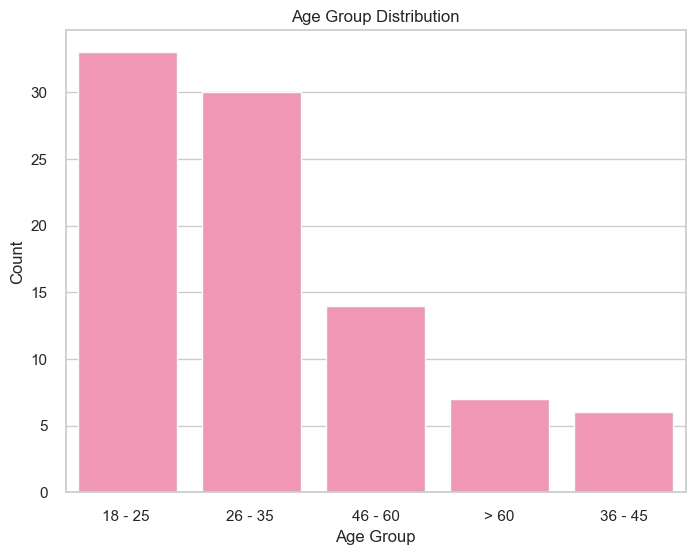

In [44]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="age_group", order=df['age_group'].value_counts().index, color="#fe88b1", legend=False)
plt.title("Age Group Distribution")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.show()

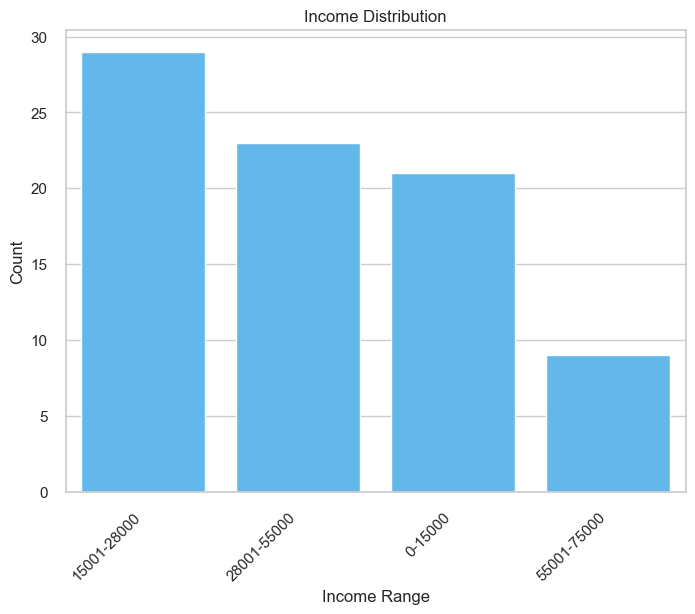

In [45]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="income", order=df['income'].value_counts().index, color="#4ebcff", legend=False)
plt.title("Income Distribution")
plt.xlabel("Income Range")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.show()

**Income Distribution:**
- The majority of customers fall in the middle-income ranges (15,001–28,000 and 28,001–55,000), with relatively fewer in the lowest and highest income groups.
- This suggests a target audience with moderate purchasing power.

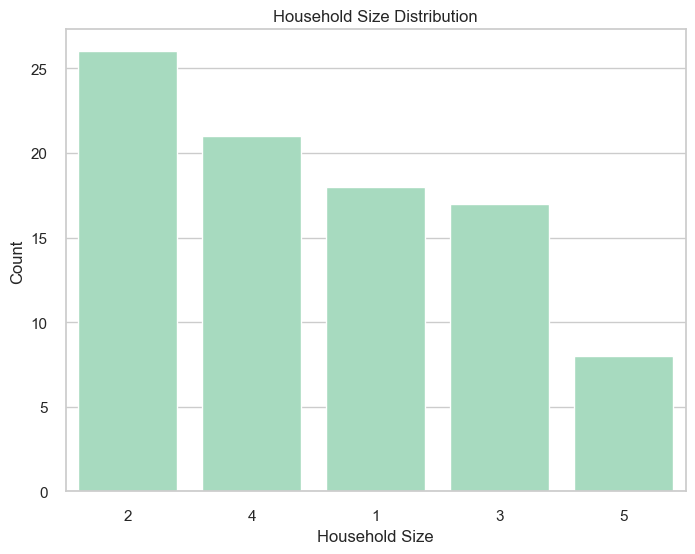

In [46]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="household_size", order=df['household_size'].value_counts().index, color="#9FE2BF", legend=False)
plt.title("Household Size Distribution")
plt.xlabel("Household Size")
plt.ylabel("Count")
plt.show()

**Household Size Distribution:**
- Most households have 2 members, followed by households with 4 members.
- Single-member and larger households (5 members) are less common, indicating energy consumption strategies could focus on small- to mid-sized households.

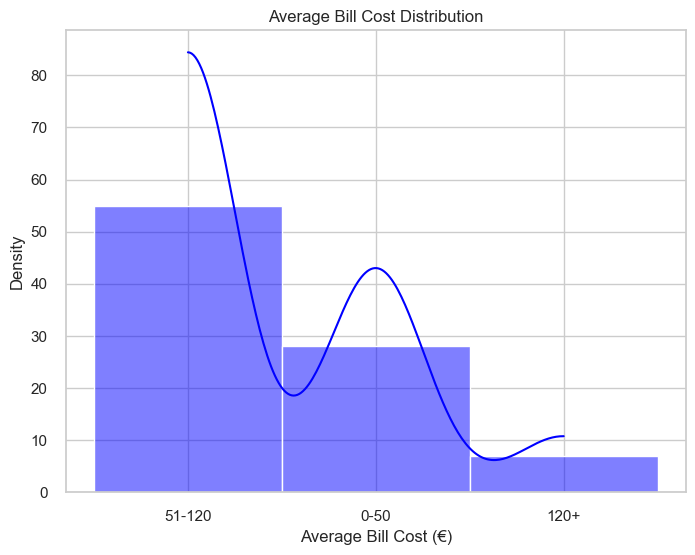

In [47]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x="average_bill_cost", bins=10, kde=True, color="blue")
plt.title("Average Bill Cost Distribution")
plt.xlabel("Average Bill Cost (€)")
plt.ylabel("Density")
plt.show()

**Average Bill Cost Distribution:**
- The majority of customers fall into the 51–120€ bill range, with smaller groups in 0–50€ and 120+€.
- This distribution indicates that most customers have moderate energy usage and spending.

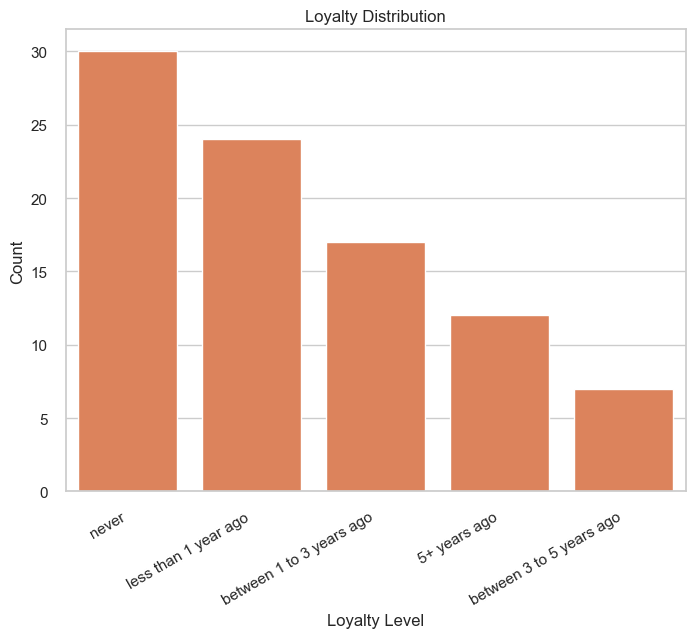

In [48]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="loyalty", order=df['loyalty'].value_counts().index, color="#f27a46", legend=False)
plt.title("Loyalty Distribution")
plt.xlabel("Loyalty Level")
plt.ylabel("Count")
plt.xticks(rotation=30, ha='right')
plt.show()

**Loyalty Distribution:**
- A significant portion of customers have never switched providers, while many switched providers less than 1 year ago.
- Retention efforts should focus on newer customers to reduce churn.

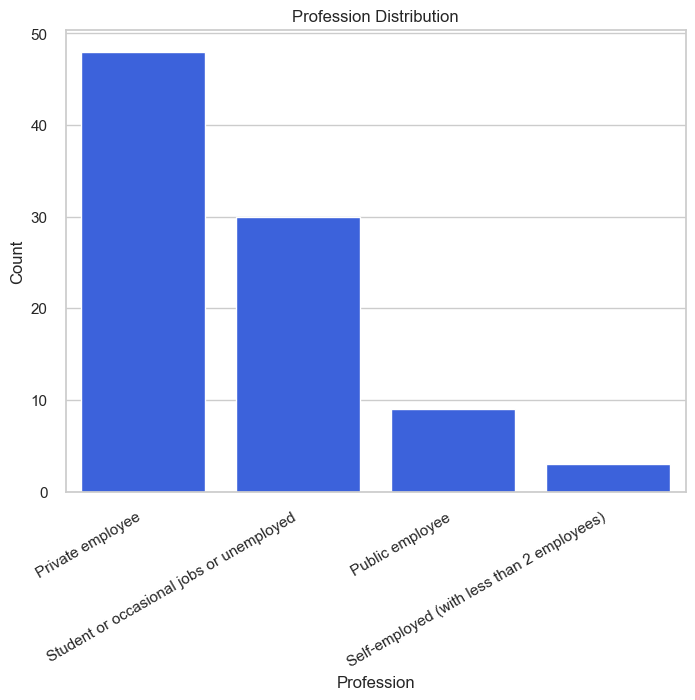

In [49]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="profession", order=df['profession'].value_counts().index, color="#2254F5", legend=False)
plt.title("Profession Distribution")
plt.xlabel("Profession")
plt.ylabel("Count")
plt.xticks(rotation=30, ha='right')
plt.show()

**Profession Distribution:**
- Private employees dominate, followed by students/unemployed and public employees.
- Energy plans and marketing efforts could prioritize working professionals, with tailored offerings for students.

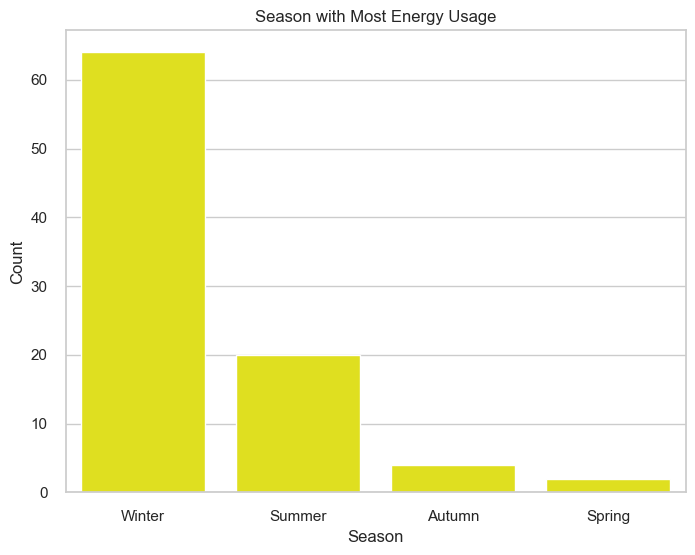

In [50]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="season", order=df['season'].value_counts().index, color="yellow", legend=False)
plt.title("Season with Most Energy Usage")
plt.xlabel("Season")
plt.ylabel("Count")
plt.show()

**Season with Most Energy Usage:**
- Energy usage peaks in Winter, followed by Summer, with minimal usage during Autumn and Spring.
- Marketing campaigns could align with seasonal peaks, promoting energy-efficient solutions during winter and summer.

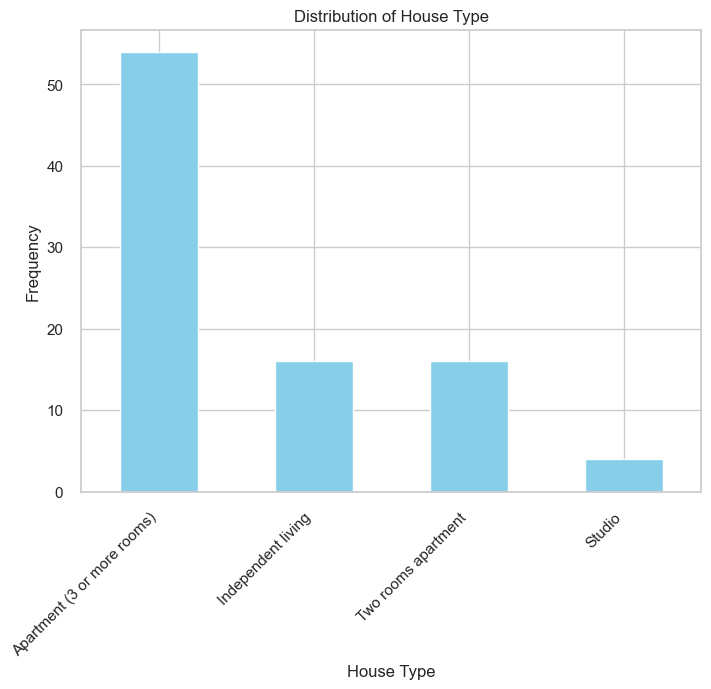

In [51]:
plt.figure(figsize=(8, 6))
df['house_type'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of House Type')
plt.xlabel('House Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()


**Distribution of House Type:**
- Most households live in apartments with 3 or more rooms, followed by independent living and two-room apartments.
- Studios are the least common, indicating that the majority of customers may require higher energy usage due to larger spaces.


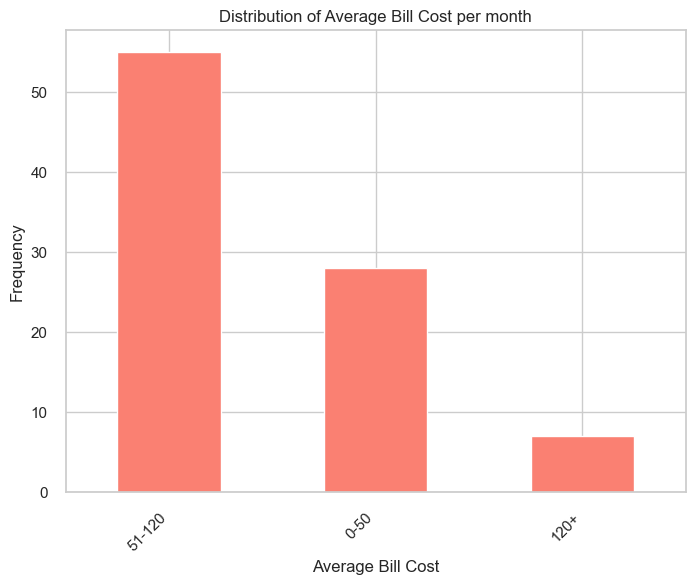

In [52]:
plt.figure(figsize=(8, 6))
df['average_bill_cost'].value_counts().plot(kind='bar', color='salmon')
plt.title('Distribution of Average Bill Cost per month')
plt.xlabel('Average Bill Cost')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

**Distribution of Average Bill Cost per Month:**
- A significant portion of customers fall within the 51–120€ bill range, while fewer customers pay less than 50€ or more than 120€.
- This suggests that most customers are mid-tier energy consumers.

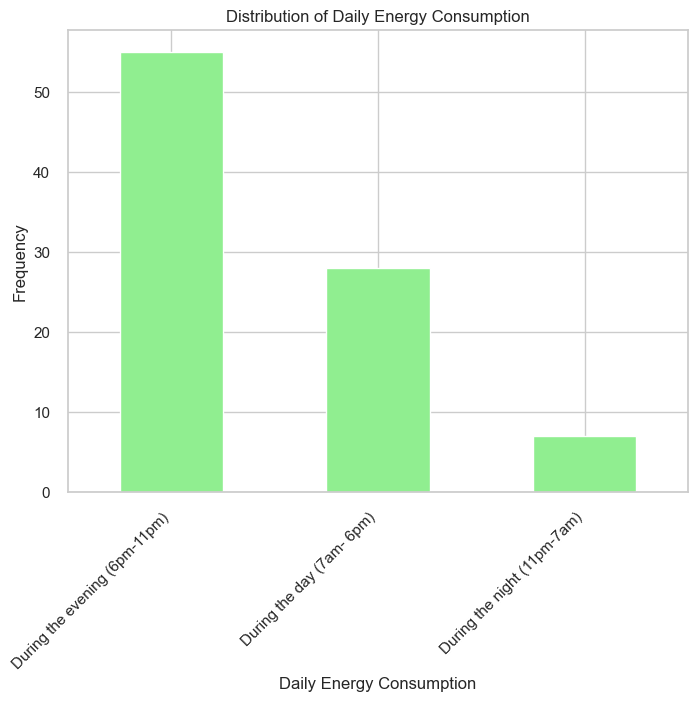

In [53]:
plt.figure(figsize=(8, 6))
df['daily_energy_consumption'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Distribution of Daily Energy Consumption')
plt.xlabel('Daily Energy Consumption')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

**Distribution of Daily Energy Consumption:**
- The majority of customers consume energy during the evening (6 PM–11 PM), followed by daytime (7 AM–6 PM) usage.
- Energy consumption during the night (11 PM–7 AM) is minimal, indicating peak usage times in the evening.

In [54]:
appliances_columns = ['washing_machine', 'dishwasher', 'clothes_dryer', 'water_heater', 'electric_oven']
rank_frequencies = {f'rank {i}': {appliance: 0 for appliance in appliances_columns} for i in range(1, 6)}

for _, row in df.iterrows():
    for appliance in appliances_columns:
        rank = row[appliance]
        rank_frequencies[f'rank {rank}'][appliance] += 1

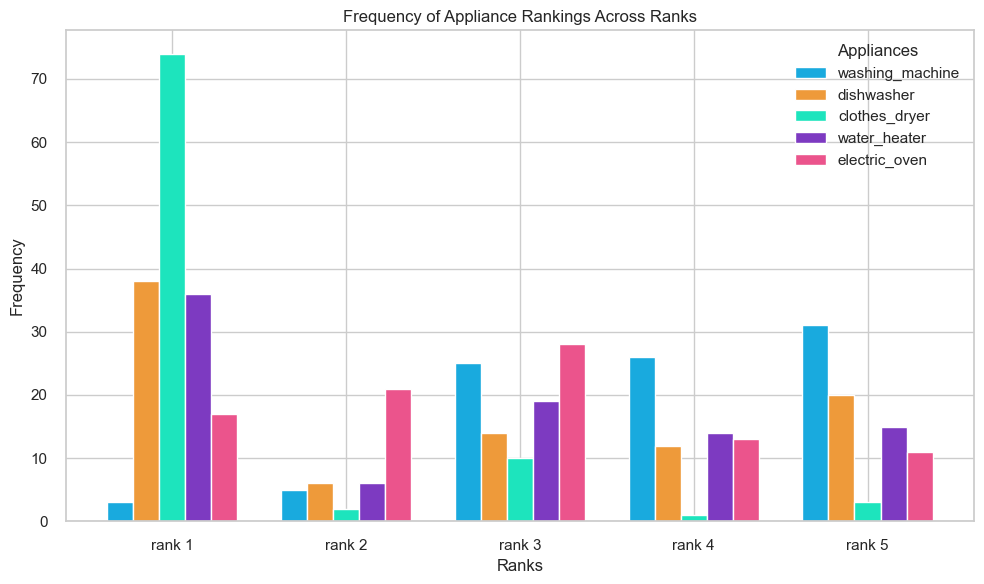

In [55]:
ranks = list(rank_frequencies.keys())
appliances = list(rank_frequencies['rank 1'].keys())
appliance_colors = {
    'washing_machine': '#19AADE',
    'dishwasher': '#EE9A3A',
    'clothes_dryer': '#1DE4BD',
    'water_heater': '#7D3AC1',
    'electric_oven': '#EB548C'
}

appliance_frequencies = {appliance: [rank_frequencies[rank][appliance] for rank in ranks] for appliance in appliances}

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.15
index = range(len(ranks))

for idx, appliance in enumerate(appliances):
    ax.bar([i + bar_width * idx for i in index], appliance_frequencies[appliance],
           width=bar_width, label=appliance, color=appliance_colors[appliance])

ax.set_xlabel('Ranks')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Appliance Rankings Across Ranks')
ax.set_xticks([i + bar_width * 2 for i in index])
ax.set_xticklabels(ranks)
ax.legend(title="Appliances")
plt.tight_layout()
plt.show()


1. **Rank 1**: The **clothes dryer** has the highest frequency for rank 1, indicating that it is most frequently considered the most important appliance. Other appliances, like the **dishwasher** and **water heater**, are also common but less dominant.

2. **Rank 2**: The **water heater** and **electric oven** are most frequently ranked second, suggesting moderate importance for these appliances.

3. **Rank 3**: **Washing machine** and **electric oven** have the highest frequency in rank 3, showing that they are commonly ranked in the middle.

4. **Rank 4**: **Washing machine** dominates rank 4, followed by **water heater** and **electric oven**, suggesting reduced importance for these appliances at this rank.

5. **Rank 5**: The **washing machine** and **dishwasher** are most commonly ranked last, suggesting these appliances are least important compared to others.

**To sum up**:
- **Clothes dryer** is the most valued appliance at rank 1.
- **Washing machine** frequently appears in the lower ranks (4 and 5).
- Different appliances hold varying importance based on individual preferences or household needs.

# Segmentation

In [56]:
columns_to_drop = ['gender', 'profession', 'nationality', 'country_of_residence', 'region_(italy)', 'region_(spain)', 'owner_of_his/her_contract']
df_cleaned = df.drop(columns=columns_to_drop)

season_map = {"Winter": 4, "Summer": 3, "Autumn": 2, "Spring": 1}

loyalty_map = {
    'less than 1 year ago': 1,
    'between 1 to 3 years ago': 2,
    'between 3 to 5 years ago': 3,
    '5+ years ago': 4,
    'never': 0
}

house_type_map = {
    'Independent living': 4,
    'Apartment (3 or more rooms)': 3,
    'Two rooms apartment': 2,
    'Studio': 1
}

bill_map = {
    '120+': 3,
    '51-120': 2,
    '0-50': 1
}

df['age_group'] = df['age_group'].str.strip()
age_map = {
    '> 60': 5,
    '46 - 60': 4,
    '36 - 45': 3,
    '26 - 35': 2,
    '18 - 25': 1
}

def income_to_midpoint(income):
    if pd.isna(income):
        return None
    income_range = income.split('-')
    low = int(income_range[0].replace(',', '').strip())
    high = int(income_range[1].replace(',', '').strip())
    return (low + high) / 2

df_cleaned["season"] = df["season"].map(season_map)
df_cleaned["loyalty"] = df["loyalty"].map(loyalty_map)
df_cleaned['house_type'] = df['house_type'].map(house_type_map)
df_cleaned['average_bill_cost'] = df['average_bill_cost'].map(bill_map)
df_cleaned['age_group'] = df['age_group'].map(age_map)
df_cleaned["income"] = df["income"].apply(income_to_midpoint)
df_cleaned["income"].fillna(df_cleaned["income"].median(), inplace=True)

df_cleaned.head()

C:\Users\pooya\AppData\Local\Temp\ipykernel_27444\3190471906.py:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned["income"].fillna(df_cleaned["income"].median(), inplace=True)


,id,age_group,income,household_size,house_type,average_bill_cost,washing_machine,dishwasher,clothes_dryer,water_heater,electric_oven,daily_energy_consumption,season,loyalty,times_energy_provider_changed
0,1,5,65000.5,3,4,2,3,3,1,1,5,During the day (7am- 6pm),3,1,1.0
1,2,5,65000.5,3,4,1,2,1,1,1,1,During the evening (6pm-11pm),4,1,1.0
2,3,3,41500.5,1,3,2,5,5,1,1,3,During the day (7am- 6pm),3,4,1.0
3,4,2,21500.5,5,3,1,5,1,1,5,1,During the evening (6pm-11pm),4,0,2.0
4,5,5,7500.0,2,3,2,3,1,1,1,3,During the evening (6pm-11pm),4,1,3.0


In [57]:
categorical_columns = df_cleaned.select_dtypes(include=['object']).columns
categorical_columns = categorical_columns.append(pd.Index(['income']))
df_cleaned = df_cleaned.copy()

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col].astype(str))
    label_encoders[col] = le

appliance_columns = ["washing_machine", "dishwasher", "clothes_dryer", "water_heater", "electric_oven"]
for col in appliance_columns:
    max_rank = df_cleaned[col].max()
    df_cleaned[col] = max_rank + 1 - df_cleaned[col]

scaler = StandardScaler()
numerical_columns = df_cleaned.columns.difference(categorical_columns + ['id'])
df_cleaned[numerical_columns] = scaler.fit_transform(df_cleaned[numerical_columns])

df_cleaned.head()

,id,age_group,income,household_size,house_type,average_bill_cost,washing_machine,dishwasher,clothes_dryer,water_heater,electric_oven,daily_energy_consumption,season,loyalty,times_energy_provider_changed
0,-1.712912,2.116029,0.708580,0.219560,1.502191,0.403473,0.807135,-0.204124,0.426076,1.059084,-1.771925,-1.325698,-0.920137,-0.301092,-1.209416
1,-1.674419,2.116029,0.708580,0.219560,1.502191,-1.325698,1.750539,1.020621,0.426076,1.059084,1.417540,0.403473,0.558655,-0.301092,-1.209416
2,-1.635927,0.580201,-0.130528,-1.361274,0.122628,0.403473,-1.079674,-1.428869,0.426076,1.059084,-0.177192,-1.325698,-0.920137,1.896064,-1.209416
3,-1.597434,-0.187712,-0.969636,1.800394,0.122628,-1.325698,-1.079674,1.020621,0.426076,-1.552356,1.417540,0.403473,0.558655,-1.033477,0.086387
4,-1.558942,2.116029,1.547689,-0.570857,0.122628,0.403473,0.807135,1.020621,0.426076,1.059084,-0.177192,0.403473,0.558655,-0.301092,1.382189


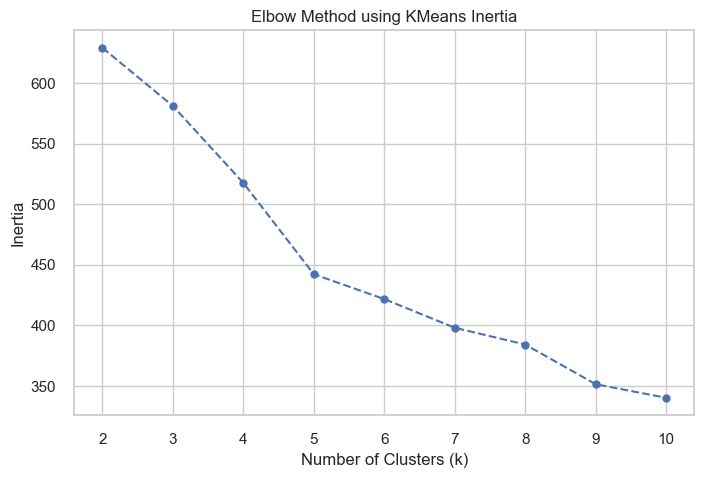

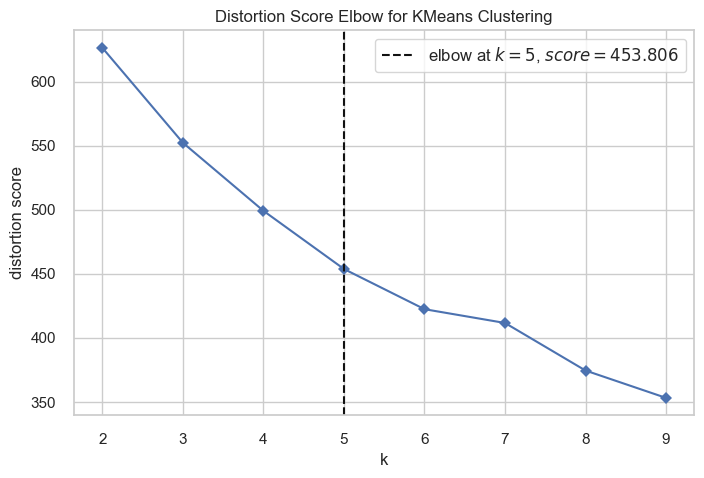

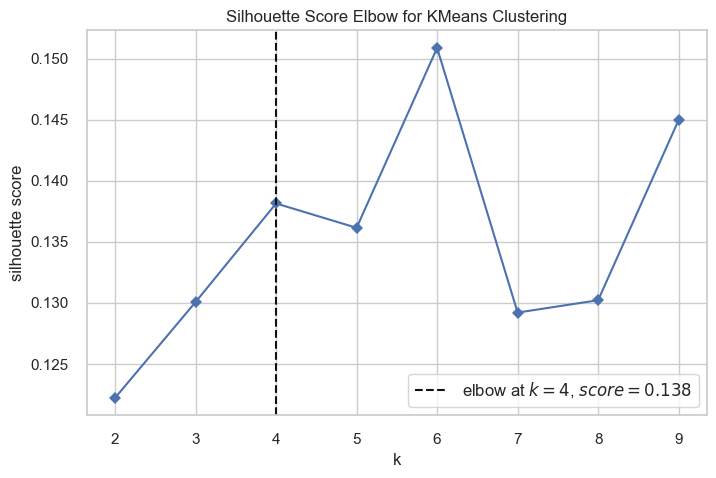

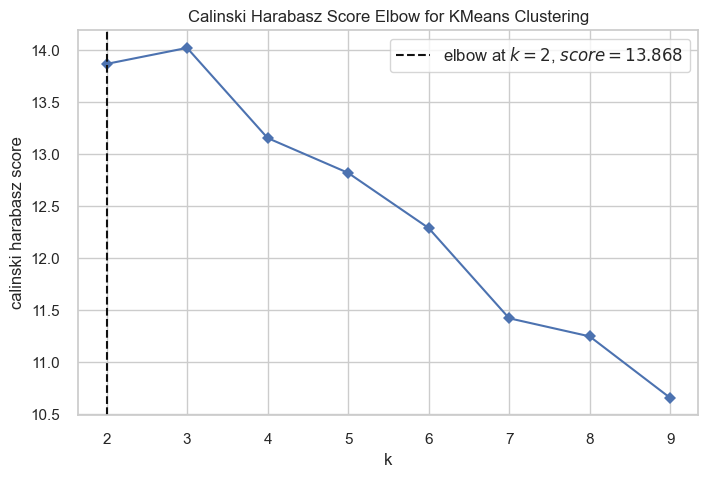

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [58]:
df_cleaned= df_cleaned.drop(columns=["washing_machine", "dishwasher", "clothes_dryer", "water_heater", "electric_oven", "daily_energy_consumption"])
X = df_cleaned.drop(columns=['id'])

inertia = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker="o", linestyle="--")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method using KMeans Inertia")
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
visualizer = KElbowVisualizer(KMeans(), k=(2, 10), metric='distortion', timings=False, ax=ax)
visualizer.fit(X)
visualizer.show()

fig, ax = plt.subplots(figsize=(8, 5))
visualizer = KElbowVisualizer(KMeans(), k=(2, 10), metric='silhouette', timings=False, ax=ax)
visualizer.fit(X)
visualizer.show()

fig, ax = plt.subplots(figsize=(8, 5))
visualizer = KElbowVisualizer(KMeans(), k=(2, 10), metric='calinski_harabasz', timings=False, ax=ax)
visualizer.fit(X)
visualizer.show()


For n_clusters = 2 The average silhouette_score is : 0.11010197987025225
For n_clusters = 3 The average silhouette_score is : 0.11204650306041089
For n_clusters = 4 The average silhouette_score is : 0.10459778728434442
For n_clusters = 5 The average silhouette_score is : 0.12319272815053121


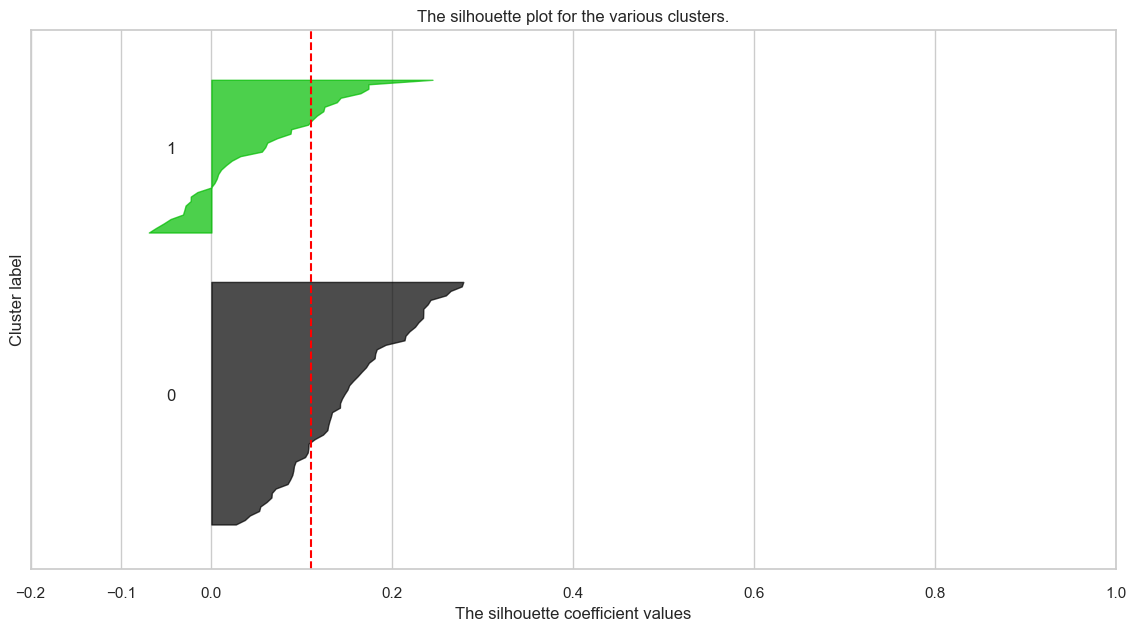

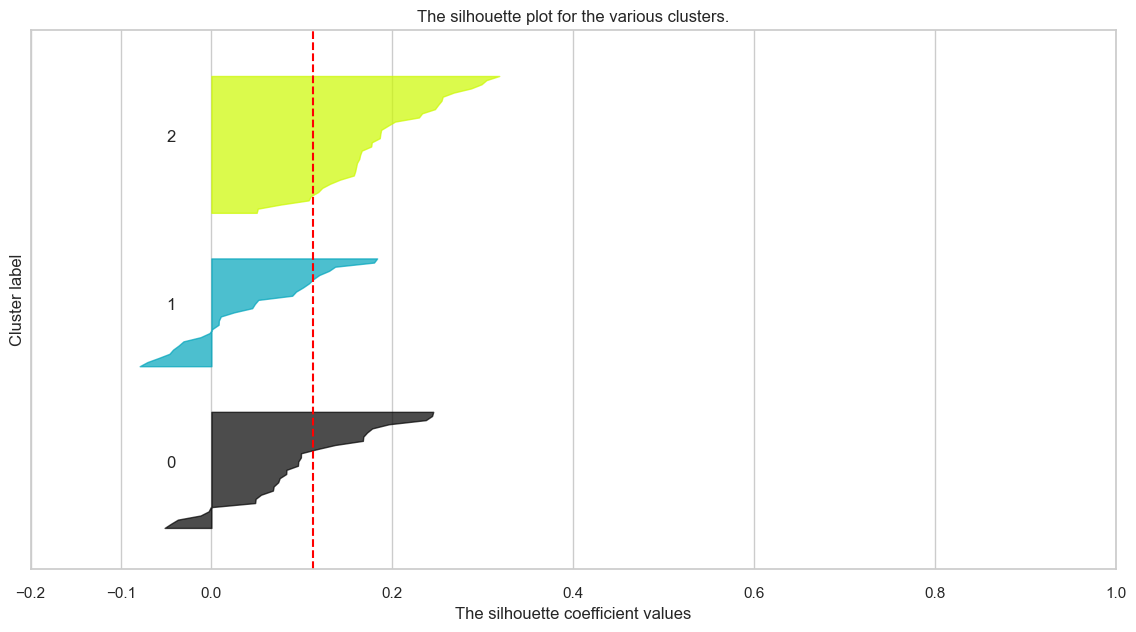

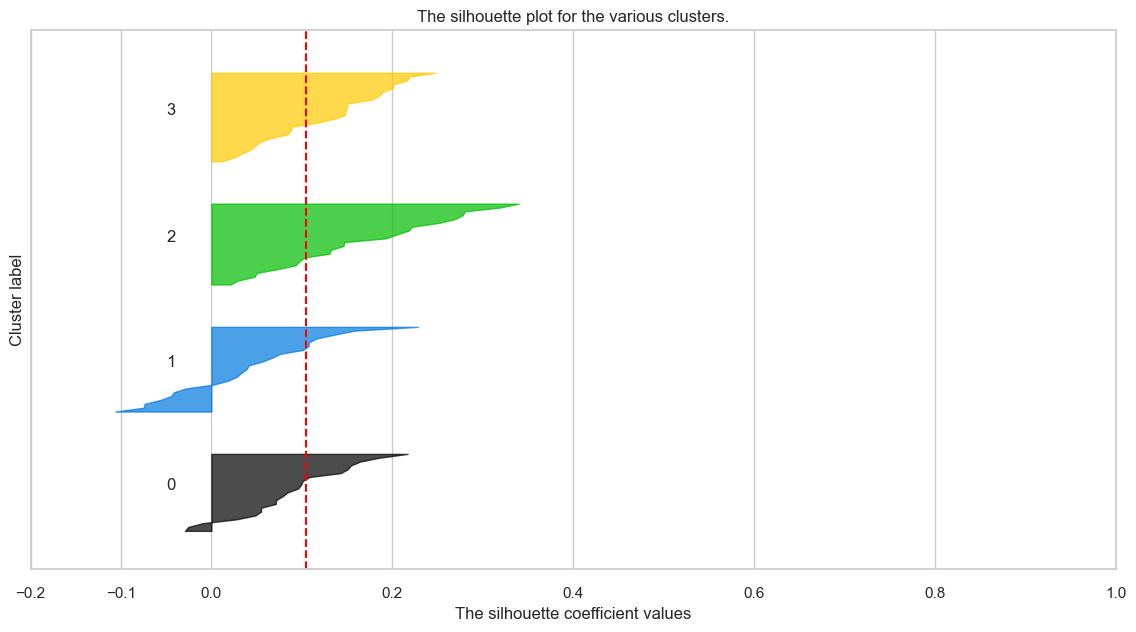

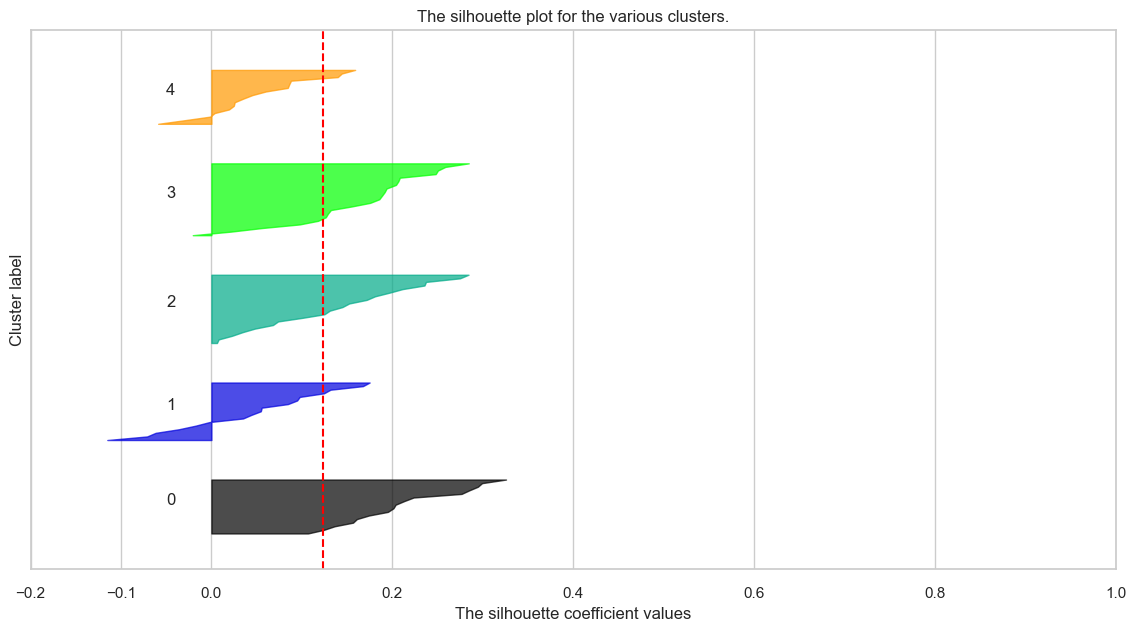

In [59]:
X = df_cleaned.to_numpy()
range_n_clusters = [2, 3, 4, 5]


for n_clusters in range_n_clusters:
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 7)
    ax.set_xlim([-0.2, 1])
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters,random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])
    ax.set_xticks([-0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

In [60]:
X = df_cleaned.drop(columns=['id'])
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)
cluster_labels = cluster_labels + 1

df_cleaned['Cluster'] = cluster_labels

df_cleaned.head(15)

,id,age_group,income,household_size,house_type,average_bill_cost,season,loyalty,times_energy_provider_changed,Cluster
0,-1.712912,2.116029,0.708580,0.219560,1.502191,0.403473,-0.920137,-0.301092,-1.209416,1
1,-1.674419,2.116029,0.708580,0.219560,1.502191,-1.325698,0.558655,-0.301092,-1.209416,1
2,-1.635927,0.580201,-0.130528,-1.361274,0.122628,0.403473,-0.920137,1.896064,-1.209416,4
3,-1.597434,-0.187712,-0.969636,1.800394,0.122628,-1.325698,0.558655,-1.033477,0.086387,2
4,-1.558942,2.116029,1.547689,-0.570857,0.122628,0.403473,0.558655,-0.301092,1.382189,1
5,-1.520450,1.348115,-0.969636,1.009977,1.502191,2.132645,-3.877721,-0.301092,1.382189,1
6,-1.481957,1.348115,-0.969636,-0.570857,1.502191,0.403473,0.558655,-0.301092,1.382189,1
7,-1.443465,-0.955626,0.708580,0.219560,-1.256936,0.403473,0.558655,0.431294,0.086387,2
8,-1.404972,1.348115,-0.130528,1.009977,0.122628,0.403473,0.558655,-0.301092,1.382189,1
9,-1.366480,2.116029,-0.969636,-0.570857,1.502191,-1.325698,0.558655,-0.301092,-1.209416,1


In [61]:
segment_sizes = df_cleaned['Cluster'].value_counts().sort_index()

segment_sizes
total = segment_sizes.sum()
segment_percentages = (segment_sizes / total * 100).round(2)

summary_table = pd.DataFrame({
    "Population": segment_sizes.values,
    "Percentage %": segment_percentages.values
}, index=segment_sizes.index)
summary_table.index.name = "SegmentKM"

summary_table


,Population,Percentage %
SegmentKM,,
1,21,23.33
2,23,25.56
3,28,31.11
4,18,20.00


In [65]:
df_Means = df_cleaned.groupby('Cluster').mean().T
def style_cols(col):
    if col.name == "Population":
        return ["background-color: white"] * len(col)

    segment = df_cleaned[df_cleaned.Cluster == col.name]
    rest_pop = df_cleaned[df_cleaned.Cluster != col.name]

    colors = []
    for var_name, var_segment_mean in col.items():
        t_test, p_value = stats.ttest_ind(segment[var_name], rest_pop[var_name], equal_var=False)
        if p_value < 0.05:
            color = "background-color: green" if var_segment_mean > rest_pop[var_name].mean() else "background-color: red"
        elif p_value < 0.1:
            color = "background-color: #90ee90" if var_segment_mean > rest_pop[var_name].mean() else "background-color: #f1807e"
        else:
            color = "background-color: white"
        colors.append(color)
    return colors

df_Means.style.apply(style_cols).format("{:.2f}")

Cluster,1,2,3,4
id,-0.07,0.13,-0.01,-0.07
age_group,1.57,-0.69,-0.49,-0.19
income,-0.29,0.96,-0.70,0.20
household_size,-0.04,0.80,-0.03,-0.92
house_type,0.71,-0.06,0.07,-0.87
average_bill_cost,0.24,-0.65,0.65,-0.46
season,-0.22,0.43,0.45,-1.00
loyalty,0.22,-0.40,-0.14,0.47
times_energy_provider_changed,0.21,-0.03,0.13,-0.42


### Segments Description:
**Cluster 1:**
- Older Age Group (1.57): This cluster consists of individuals in older age brackets.
- High House Type Preference (0.71): Likely indicates larger homes or higher energy requirements due to the type of house.
- Moderate Loyalty (0.22): Slightly more loyal to their energy provider.
- **Description: Older, large-house consumers.** Likely households with high energy needs and stable loyalty.

**Cluster 2:**
- High Income (0.96): This cluster has significantly higher incomes compared to the others.
- Large Household Size (0.80): Larger households on average.
- Seasonal Sensitivity (0.43): Energy consumption varies more with the season.
- Low Loyalty (-0.40): Less loyal to their energy provider.
- **Description: High-income, large-house, seasonal users.** These consumers may benefit from personalized plans or loyalty incentives.

**Cluster 3:**
- Low Income (-0.70): This cluster represents individuals with lower incomes.
- Moderate Energy Bill (0.65): Despite lower income, they have higher-than-average energy bills.
- Moderate Seasonal Sensitivity (0.45): Their energy consumption is affected by seasons.
- **Description: Low-income, moderate energy consumers.** Likely price-sensitive users who could benefit from energy-saving options or subsidies.

**Cluster 4:**
- Small Household Size (-0.92): Smallest households among the clusters.
- Low House Type (-0.87): Likely associated with smaller homes or apartments.
- High Loyalty (0.47): This group is the most loyal to their energy provider.
- Low Seasonal Sensitivity (-1.00): Their energy consumption does not vary much with seasons.
- **Description: Small, loyal, consistent users.** Ideal for retention strategies or low-consumption incentives.

**Actionable Strategies:**

- Segment 1: Focus on stable pricing plans or premium offerings for older, high-consumption users.
- Segment 2: Target high-income, seasonal users with dynamic pricing or green energy solutions.
- Segment 3: Offer energy-saving incentives or subsidies to low-income, moderate-consumption users.
- Segment 4: Reinforce loyalty through discounts or rewards for consistent, small-scale users.

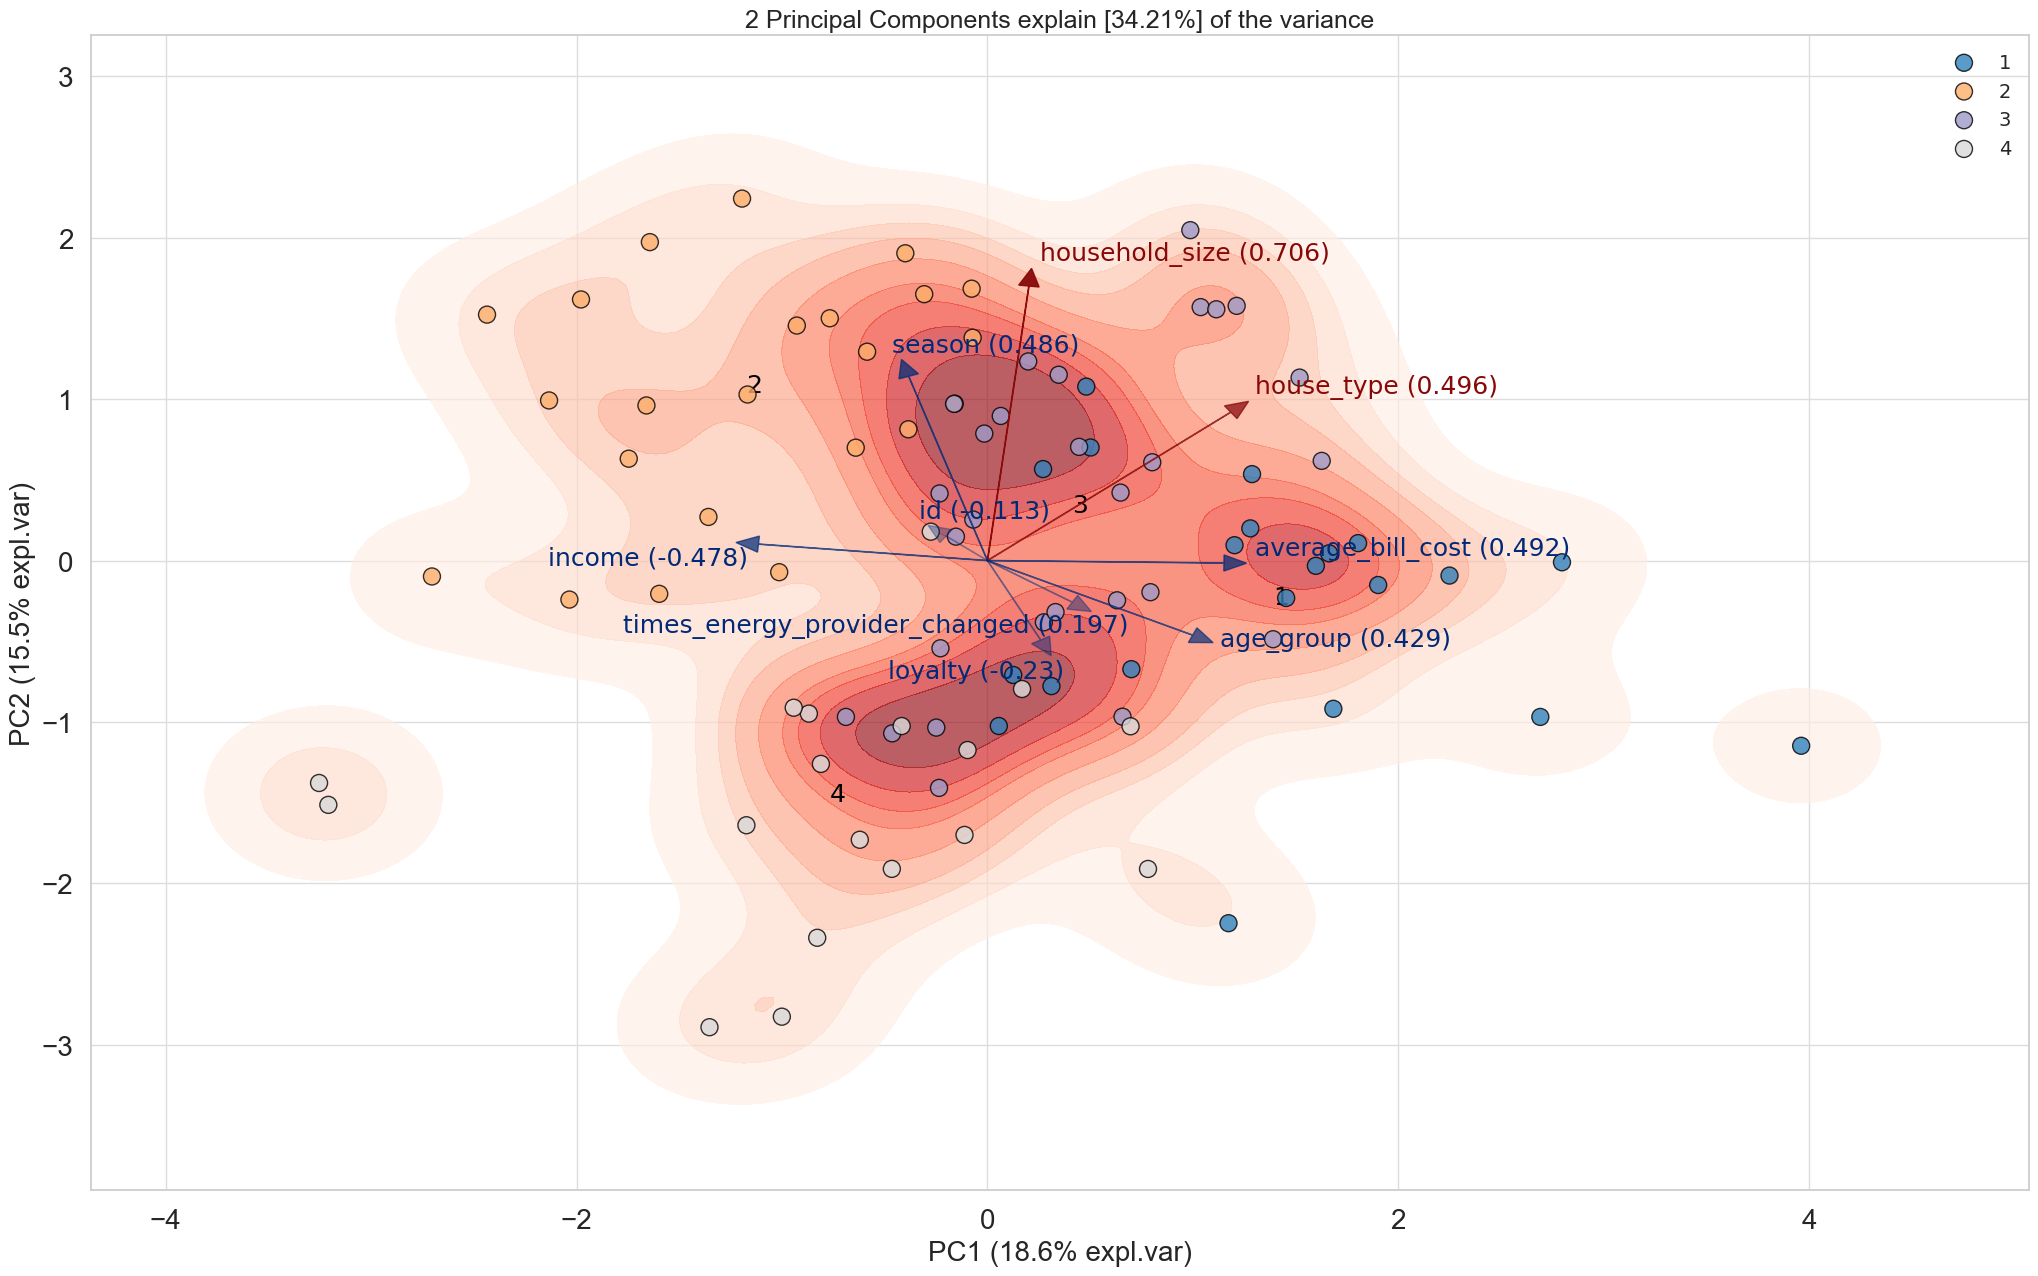

In [66]:
logging.disable(sys.maxsize)

model = pca(n_components=2,normalize=True)

features = df_cleaned.drop(columns="Cluster")
segments = df_cleaned.Cluster

results = model.fit_transform(features,verbose=False)

fig, ax = model.biplot(labels=segments,verbose=0,density=True);

c:\Users\pooya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


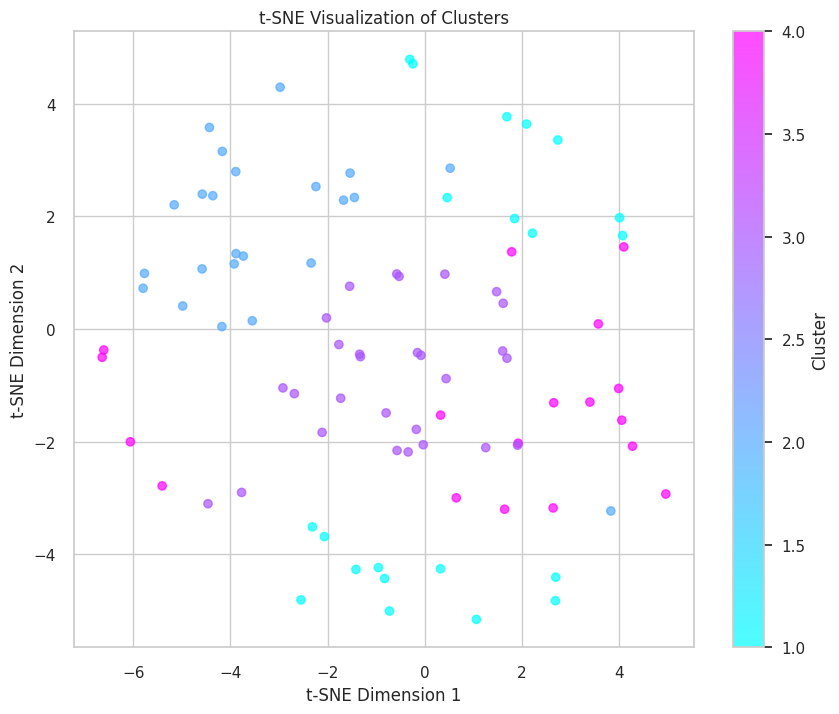

In [67]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500)
tsne_results = tsne.fit_transform(X)

df_cleaned['TSNE1'] = tsne_results[:, 0]
df_cleaned['TSNE2'] = tsne_results[:, 1]

plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_cleaned['TSNE1'], df_cleaned['TSNE2'], c=df_cleaned['Cluster'], cmap='cool', alpha=0.7)
plt.colorbar(scatter, label="Cluster")
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()


In [68]:
df_hc = df_cleaned.drop(columns=["TSNE1", "TSNE2", 'Cluster', 'id'])

hc = AgglomerativeClustering(n_clusters = 4, metric="euclidean", linkage="ward")
hc.fit(df_hc)

df_hc["ClusterHC"] = hc.labels_ + 1
df_hc.head(15)

,age_group,income,household_size,house_type,average_bill_cost,season,loyalty,times_energy_provider_changed,ClusterHC
0,2.116029,0.708580,0.219560,1.502191,0.403473,-0.920137,-0.301092,-1.209416,2
1,2.116029,0.708580,0.219560,1.502191,-1.325698,0.558655,-0.301092,-1.209416,2
2,0.580201,-0.130528,-1.361274,0.122628,0.403473,-0.920137,1.896064,-1.209416,1
3,-0.187712,-0.969636,1.800394,0.122628,-1.325698,0.558655,-1.033477,0.086387,4
4,2.116029,1.547689,-0.570857,0.122628,0.403473,0.558655,-0.301092,1.382189,2
5,1.348115,-0.969636,1.009977,1.502191,2.132645,-3.877721,-0.301092,1.382189,2
6,1.348115,-0.969636,-0.570857,1.502191,0.403473,0.558655,-0.301092,1.382189,2
7,-0.955626,0.708580,0.219560,-1.256936,0.403473,0.558655,0.431294,0.086387,3
8,1.348115,-0.130528,1.009977,0.122628,0.403473,0.558655,-0.301092,1.382189,2
9,2.116029,-0.969636,-0.570857,1.502191,-1.325698,0.558655,-0.301092,-1.209416,2


In [69]:
segment_sizes = df_hc['ClusterHC'].value_counts().sort_index()

segment_sizes
total = segment_sizes.sum()
segment_percentages = (segment_sizes / total * 100).round(2)

summary_table = pd.DataFrame({
    "Population": segment_sizes.values,
    "Percentage %": segment_percentages.values
}, index=segment_sizes.index)
summary_table.index.name = "SegmentHC"

summary_table

,Population,Percentage %
SegmentHC,,
1,31,34.44
2,24,26.67
3,17,18.89
4,18,20.00


In [70]:
df_Means_hc = df_hc.groupby("ClusterHC").mean().T
df_Means_hc.insert(0,"Population", df_hc.drop(columns="ClusterHC").mean())
df_Means_hc.round(2)

def style_cols(col):
    if col.name == "Population":
        return ["background-color: white"] * len(col)

    segment = df_hc[df_hc.ClusterHC == col.name]
    rest_pop = df_hc[df_hc.ClusterHC != col.name]

    colors = []
    for var_name, var_segment_mean in col.items():
        t_test, p_value = stats.ttest_ind(segment[var_name], rest_pop[var_name], equal_var=False)
        if p_value < 0.05:
            color = "background-color: green" if var_segment_mean > rest_pop[var_name].mean() else "background-color: red"
        elif p_value < 0.1:
            color = "background-color: #90ee90" if var_segment_mean > rest_pop[var_name].mean() else "background-color: #f1807e"
        else:
            color = "background-color: white"
        colors.append(color)
    return colors

df_Means_hc.style.apply(style_cols).format("{:.2f}")

ClusterHC,Population,1,2,3,4
age_group,0.00,-0.34,1.35,-0.82,-0.44
income,0.00,-0.13,-0.41,1.40,-0.55
household_size,-0.00,-0.80,0.09,0.68,0.61
house_type,0.00,-0.68,0.64,-0.28,0.58
average_bill_cost,0.00,0.07,0.04,-0.51,0.31
season,-0.00,-0.44,-0.12,0.47,0.48
loyalty,0.00,0.45,0.16,-0.30,-0.71
times_energy_provider_changed,-0.00,0.00,0.03,0.09,-0.13


### Segments Description:
**Cluster 1:**
- Lower Household Size (-0.80): Households in this cluster are smaller than average.
- Lower House Type (-0.68): Likely smaller homes or apartments.
- High Loyalty (0.45): Members are more loyal to their energy providers.
- **Description: Small, loyal households.** These consumers are stable, with relatively low energy needs due to smaller households and homes.

**Cluster 2:**
- Older Age Group (1.35): This cluster primarily consists of older individuals.
- Higher House Type (0.64): Larger or more energy-intensive homes.
- Low Income (-0.41): Despite larger homes, this group has below-average income.
- Moderate Household Size (0.09): Household size is around average.
- **Description: Older, large-house, low-income consumers.** Likely to benefit from tailored energy efficiency programs or cost-saving plans.

**Cluster 3:**
- Higher Income (1.40): The wealthiest cluster compared to the others.
- Larger Household Size (0.68): Households are larger than average.
- Moderate House Type (-0.28): Home types are not as large as Cluster 2.
- High Seasonal Energy Usage (0.47): Energy usage varies significantly with seasons.
- **Description: High-income, large households, seasonal users.** This group might prefer dynamic pricing plans or premium green energy solutions.

**Cluster 4:**
- Smaller Household Size (0.61): Relatively small households.
- High House Type (0.58): Likely larger homes.
- High Seasonal Energy Usage (0.48): Energy consumption is highly influenced by seasons.
- Low Loyalty (-0.71): Least loyal cluster to their energy provider.
- **Description: Small, seasonal, low-loyalty users.** Strategies to retain this group might focus on flexible or short-term energy plans.

**Actionable Strategies:**

- Segment 1: Provide retention rewards to reinforce loyalty among small, stable households.
- Segment 2: Offer energy efficiency programs targeting older consumers with larger homes.
- Segment 3: Market premium plans or green energy options to high-income, large households.
- Segment 4: Focus on loyalty-building strategies and flexibility for seasonal energy needs.

In [71]:
df_cleaned['Cluster'].equals(df_hc['ClusterHC'].astype("int32"))

False

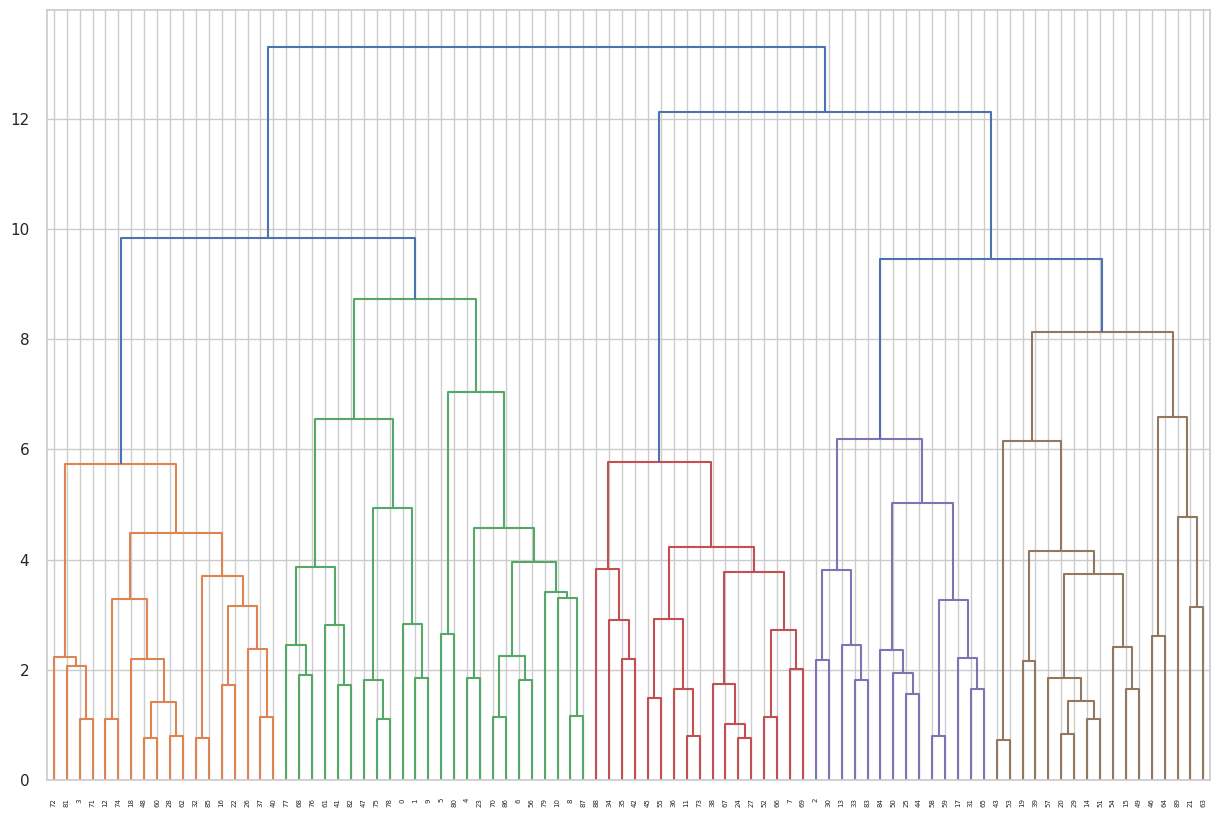

In [72]:
X = df_hc.drop(columns=["ClusterHC"])

tree = hierarchy.linkage(X,'ward')
plt.figure(figsize=(15,10))
dn = hierarchy.dendrogram(tree)

In [73]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(df_cleaned['Cluster'], df_hc['ClusterHC'])
nmi = normalized_mutual_info_score(df_cleaned['Cluster'], df_hc['ClusterHC'])
print("ARI:", ari, "NMI:", nmi)

ARI: 0.48966407415721436 NMI: 0.5930791841732754


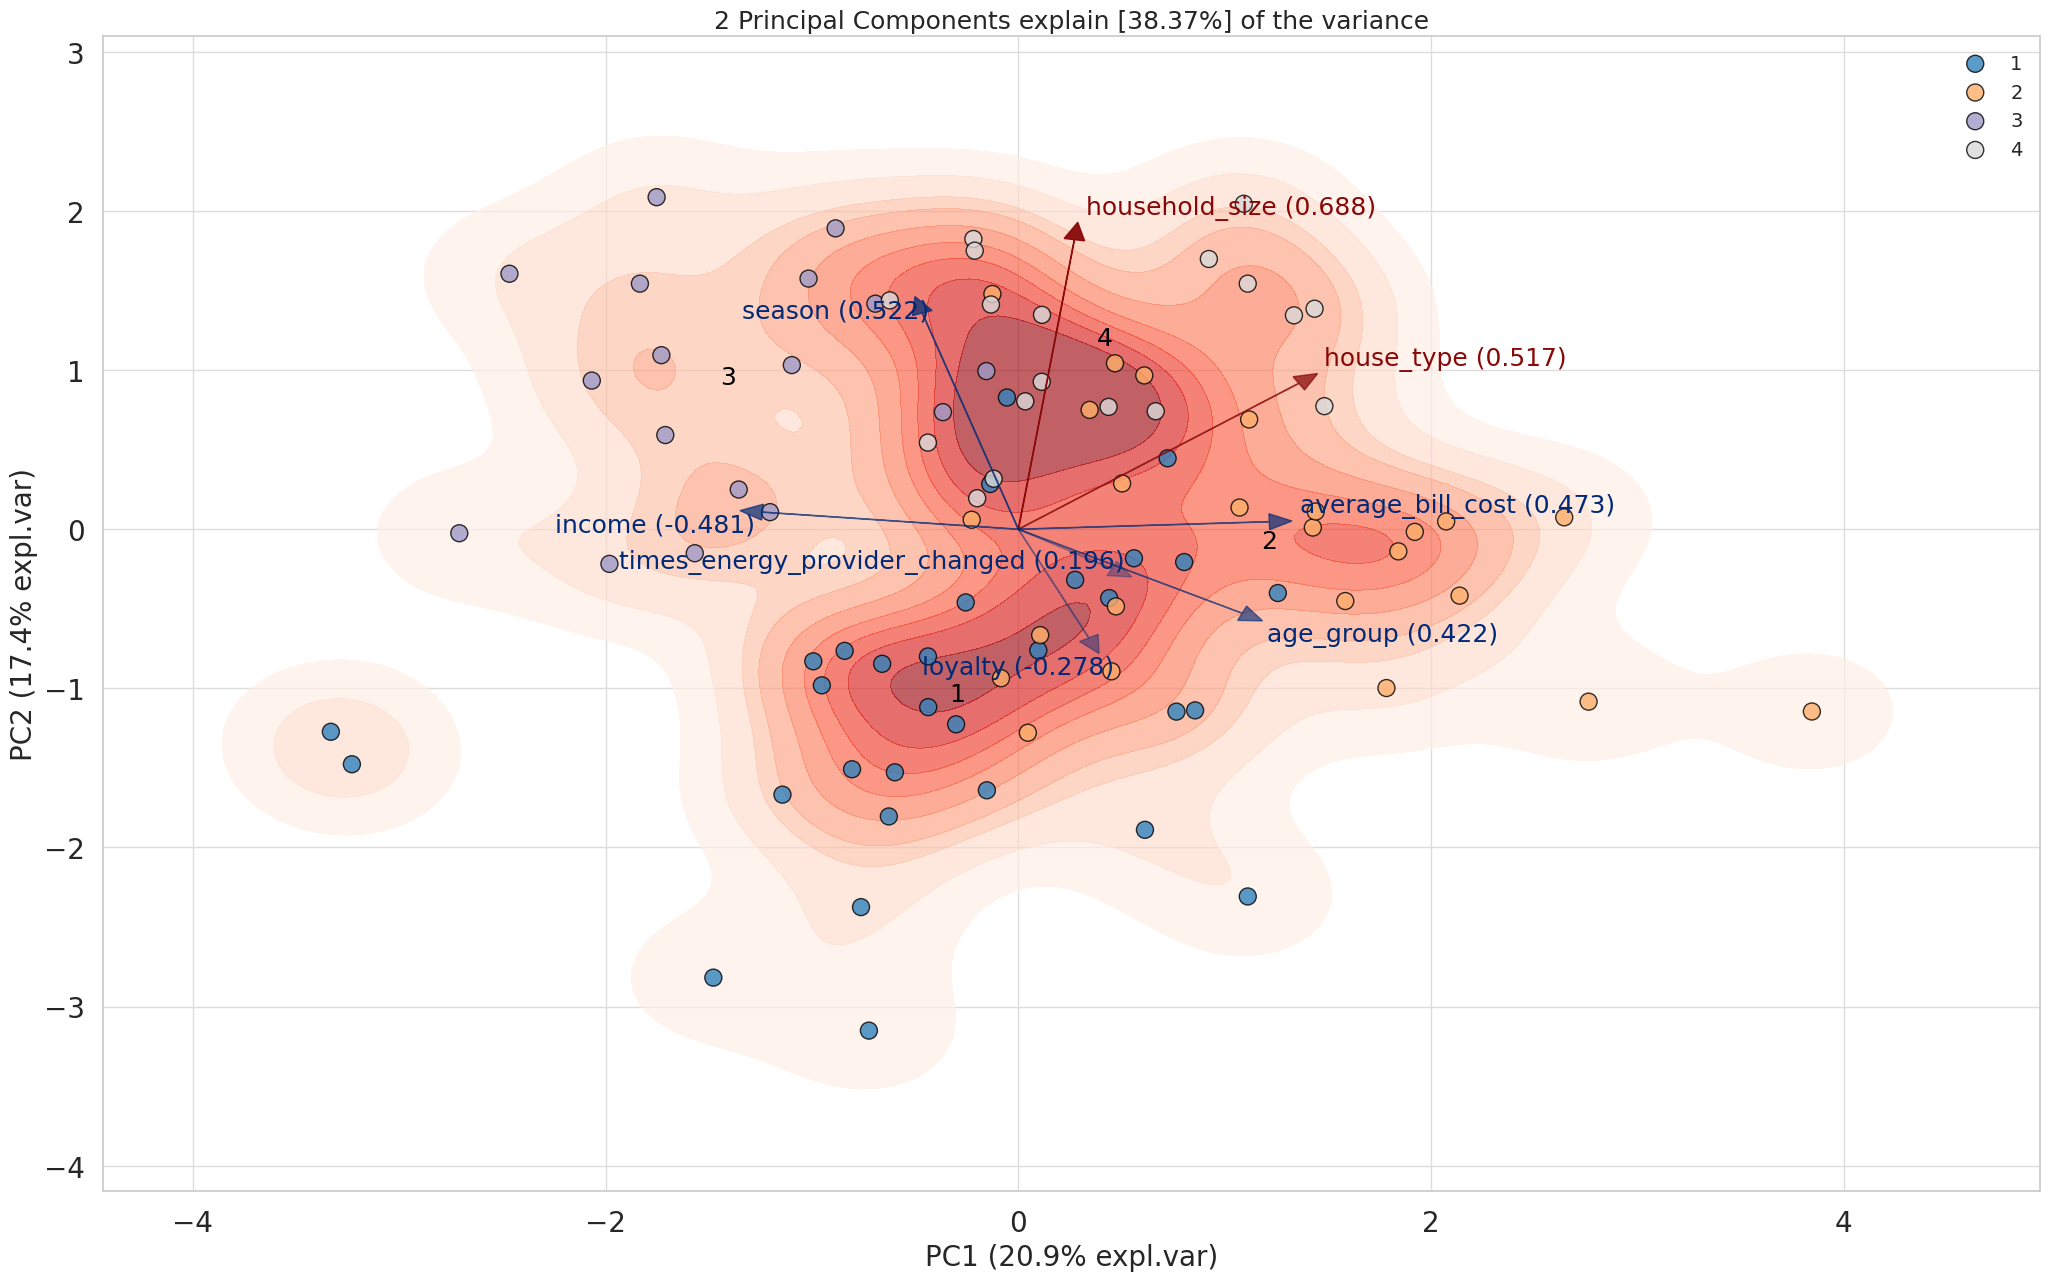

In [74]:
logging.disable(sys.maxsize)

model = pca(n_components=2,normalize=True)

features = df_hc.drop(columns="ClusterHC")
segments = df_hc.ClusterHC

results = model.fit_transform(features,verbose=False)

fig, ax = model.biplot(labels=segments,verbose=0,density=True);


c:\Users\pooya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


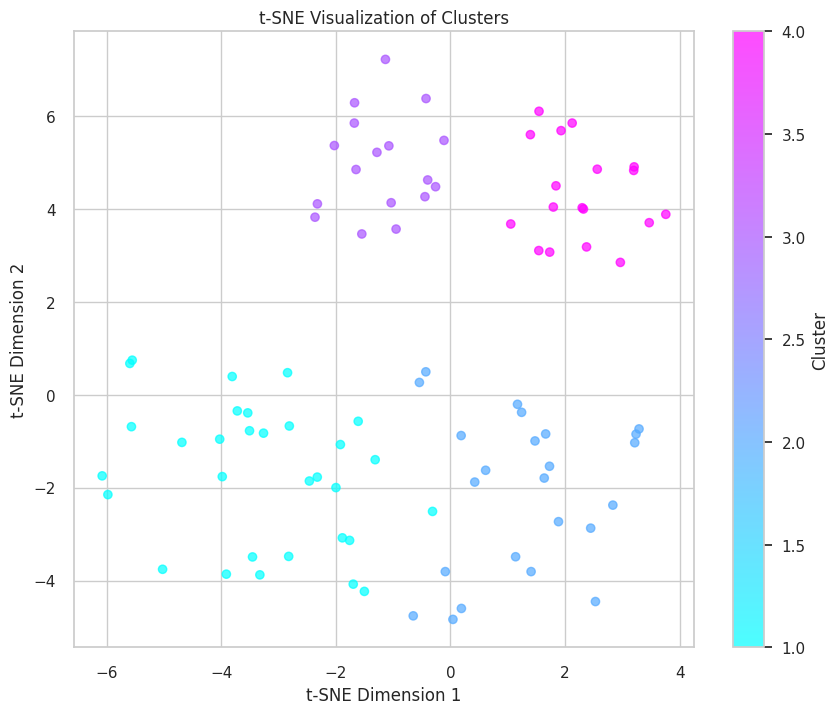

In [75]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500)
tsne_results = tsne.fit_transform(df_hc)

df_hc['TSNE1'] = tsne_results[:, 0]
df_hc['TSNE2'] = tsne_results[:, 1]

plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_hc['TSNE1'], df_hc['TSNE2'], c=df_hc['ClusterHC'], cmap='cool', alpha=0.7)
plt.colorbar(scatter, label="Cluster")
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()

In [76]:
df_cleaned['ClusterHC'] = df_hc['ClusterHC']
(df_cleaned.groupby("ClusterHC")["Cluster"].nunique()==1).all() and \
(df_cleaned.groupby("Cluster")["ClusterHC"].nunique()==1).all()


False